# **Recommender Systems or Why Your Phone Isn't Actually Spying on You**

<img src="https://drive.google.com/uc?id=1vpzhvPNf6fMdW1eettSzHHFeggNUzRZB" />

<a href="https://colab.research.google.com/github/deep-learning-indaba/indaba-pracs-2023/blob/main/practicals/Indaba_2023_Prac_Template.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a> [Change colab link to point to prac.]

© Deep Learning Indaba 2023. Apache License 2.0.

**Authors:** [Amrit Purshotam](https://nl.linkedin.com/in/amritpurshotam), [Jama Hussein Mohamud](https://engmubarak48.github.io/jmohamud/)

**Reviewers:** [Kyle Taylor](https://uk.linkedin.com/in/kylerosstaylor)

**Introduction:**

Recommender Systems are probably one of the most ubiquitous type of machine learning model that we encounter in our online life. They influence what we see in our social media feeds, the products we buy, the music we listen to, the food we eat, and the movies we watch. Sometimes they're so good that people feel that their phone is spying on their conversations! In this prac, we hope to convince you that this isn't the case (mostly) as well as taking you through some of the techniques popularly used in industry that recommends the content you see online by building our very own movie recommender system.

**Topics:**

Content: Machine Learning, Recommender Systems, Approximate Nearest Neighbours

Level: <font color='grey'>`Beginner`</font>

**Aims/Learning Objectives:**

- General architecture of a recommender systems.
- Techniques for making recommendations.
- Serving recommendations efficiently in production.

**Prerequisites:**

[Knowledge required for this prac. You can link a relevant parallel track session, blogs, papers, courses, topics etc.]

**Outline:**

>[Recommender Systems or Why Your Phone Isn't Actually Spying on You](#scrollTo=m2s4kN_QPQVe)

>>[Installation and Imports](#scrollTo=6EqhIg1odqg0)

>>[1. Recommender Systems Overview](#scrollTo=-ZUp8i37dFbU)

>>>[1.1 A Real World Scenario](#scrollTo=-ZUp8i37dFbU)

>>>[1.2 Recommendation System Architecture](#scrollTo=Ox8aHBxO4luZ)

>>>>[1.2.1 Overview](#scrollTo=Ox8aHBxO4luZ)

>>>>[1.2.2 Zooming in](#scrollTo=Ox8aHBxO4luZ)

>>[2. Collaborative Filtering](#scrollTo=YiXBlHjrb0DJ)

>>>[2.1 Overview](#scrollTo=YiXBlHjrb0DJ)

>>>[2.2 Matrix Factorisation](#scrollTo=YiXBlHjrb0DJ)

>>>[2.3 The MovieLens Dataset](#scrollTo=YiXBlHjrb0DJ)

>>>[2.2 Dataset Preparation](#scrollTo=Dj9F3b3Cictf)

>>>[2.3 Building our Model](#scrollTo=9et6qbJeMRJ7)

>>>>[2.3.1 Dot Product Model](#scrollTo=9LcnAgsROHew)

>>>>[2.3.2 Dot Product with Bias Model](#scrollTo=_ybIOHsUMZao)

>>>>>[2.3.2.1 Mitigate overfitting](#scrollTo=yMryLaMquEXA)

>>>[2.4 Interpreting our Model](#scrollTo=34kiVmBcNKxi)

>>>>[2.4.1 Biases](#scrollTo=34kiVmBcNKxi)

>>>>[2.4.2 Embedding Distance](#scrollTo=LoqRWHL4bzcY)

>>>[2.5 Making Recommendations (WIP)](#scrollTo=s_ZxySJNNLpj)

>>>[2.6. Approximate Nearest Neighbours](#scrollTo=_W5tQW6oD_9Z)

>>>[2.7. Types of Feedback (WIP)](#scrollTo=pfX_PVxWSEOL)

>>[3. Building recommender systems using GNNs](#scrollTo=mjWXX3vf_MH3)

>>>[3.1. Recap of graph fundamentals](#scrollTo=dLiatNhIyP33)

>>>>[3.1.2. Graph Neural Network Theory](#scrollTo=WZpm6OM0L7Rc)

>>>[3.2. Graph Prediction Tasks](#scrollTo=qc-PDBzFl3Mc)

>>>[3.3. Formulating Recommender systems as a graph problem](#scrollTo=MdhAhUTtpWj2)

>>>>[3.3.1. Link (or Edge) Prediction](#scrollTo=O-YcvPGDSXvF)

>>>>[3.3.2. Inference](#scrollTo=x2ufCvuiIZOg)

>>[Conclusion](#scrollTo=fV3YG7QOZD-B)

>>[Feedback](#scrollTo=o1ndpYE50BpG)

**Before you start:**

For this practical, you will need to use a GPU to speed up training. To do this, go to the "Runtime" menu in Colab, select "Change runtime type" and then in the popup menu, choose "GPU" in the "Hardware accelerator" box.

**Suggested experience level in this topic:**

| Level         | Experience                            |
| --- | --- |
`Beginner`      | It is my first time being introduced to this work. |
`Intermediate`  | I have done some basic courses/intros on this topic. |
`Advanced`      | I work in this area/topic daily. |

In [ ]:
# @title **Paths to follow:** What is your level of experience in the topics presented in this notebook? (Run Cell)
experience = "advanced" #@param ["beginner", "intermediate", "advanced"]

sections_to_follow=""

if experience == "beginner":
  sections_to_follow="Introduction -> 1.1 Subsection -> 2.1 Subsection -> Conclusion -> Feedback"
elif experience == "intermediate":
  sections_to_follow="Introduction -> 1.2 Subsection -> 2.2 Subsection -> Conclusion -> Feedback"
elif experience == "advanced":
  sections_to_follow="Introduction -> 1.3 Subsection -> 2.3 Subsection -> Conclusion -> Feedback"

print(f"Based on your experience, it is advised you follow these -- {sections_to_follow} sections. Note this is just a guideline.")

## Installation and Imports

In [ ]:
# @title Installations
%%capture
!pip install annoy clu
!pip install git+https://github.com/deepmind/jraph.git
!pip install torch-geometric
!pip install networkx

In [ ]:
## Install and import anything required. Capture hides the output from the cell.
# @title Import required packages. (Run Cell)

import gc
import jax
import jraph
import optax
import torch
import numpy as np
import pandas as pd
import networkx as nx
import tensorflow as tf
from flax import struct
from clu import metrics
from flax import linen as nn
from jax import numpy as jnp
import jax.tree_util as tree
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from jraph import GraphConvolution
from flax.training import train_state
from torch_geometric.data import Data
from torch_geometric.transforms import RandomLinkSplit
from typing import Iterable, Mapping, Sequence, Tuple, Callable

SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

In [ ]:
# @title Helper methods

def get_dataset(ds_name: str) -> pd.DataFrame:
  ds, info = tfds.load(f'movielens/{ds_name}', data_dir="./data", with_info=True)
  df = tfds.as_dataframe(ds['train'], info)
  df = df.astype({'user_id': int, 'movie_id': int})
  df.loc[:, 'movie_title'] = df['movie_title'].str.decode("utf-8")
  return df

def cross_tabulate(df: pd.DataFrame, num_samples: int = 10) -> pd.DataFrame:
  pivot_df = df.pivot(index='user_id', columns='movie_id', values='user_rating')
  pivot_df = pivot_df.loc[df['user_id'].sample(num_samples), df['movie_id'].sample(num_samples)].dropna(axis=0, thresh=1).fillna("")
  return pivot_df

def make_mapping(id_set: Iterable[str]) -> Mapping[str, int]:
  return {id_str: i for (i, id_str) in enumerate(id_set)}

def densify_column_values(df: pd.DataFrame, col_name: str) -> Tuple[pd.Series, Sequence[str]]:
  col_values = sorted(set(df[col_name]))
  col_ids_map = make_mapping(col_values)
  return df[col_name].apply(lambda col_id: col_ids_map[col_id]), col_values, col_ids_map

def to_tfds(df: pd.DataFrame) -> tf.data.Dataset:
  fields = {
    ('user_id', tf.int32),
    ('item_id', tf.int32),
    ('user_rating', tf.float32),
    ('timestamp', tf.int32)
  }

  tensor_slices = {
      field: tf.cast(df[field].values, dtype=field_type)
      for field, field_type in fields
  }

  return tf.data.Dataset.from_tensor_slices(tensor_slices)

def get_train_val_split(df: pd.DataFrame):
  val_df = df.sample(frac=0.2)
  train_df = df[~df.index.isin(val_df.index)]

  return train_df, val_df

def prepare_dataloaders(train_df: pd.DataFrame, val_df: pd.DataFrame, batch_size: int, num_epochs: int):
  train_ds = (
    to_tfds(train_df)
    .repeat(config.NUM_EPOCHS)
    .shuffle(1024)
    .batch(config.BATCH_SIZE, drop_remainder=False)
    .prefetch(1)
  )
  val_ds = (
    to_tfds(val_df)
    .shuffle(1024)
    .batch(config.BATCH_SIZE, drop_remainder=False)
    .prefetch(1)
  )
  return train_ds, val_ds

def plot_metric_history(metrics_history):
  fig, ax1 = plt.subplots(1, 1, figsize=(7, 5))
  ax1.set_title('Loss')
  for dataset in ('train','val'):
    ax1.plot(metrics_history[f'{dataset}_loss'], label=f'{dataset}_loss')
  ax1.legend()
  plt.show()
  plt.clf()

In [ ]:
class Config:
    DATASET = "latest-small-ratings" # all the options are 100k-ratings 1m-ratings 20m-ratings 25m-ratings latest-small-ratings
    SEED = 42
    EMB_DIM = 50
    LR = 5e-3
    BATCH_SIZE = 64
    NUM_EPOCHS = 5

config = Config()

rng = jax.random.PRNGKey(config.SEED)
rng, model_rng, dataset_rng = jax.random.split(rng, 3)

## **1. Recommender Systems Overview**

### **1.1 A Real World Scenario**

Imagine you're going shopping for a new book. You enter the store and start walking around scanning the shelves of books. Something catches your interest, you pause, take the book down and inspect the cover, and perhaps also read the blurb. You continue to do this until you find something you like at which point you purchase the book and leave.

Now imagine you've read the book and quite enjoyed it and you want to buy another one. You go back to the store, browse around, and occasionally inspect some books that catch your interest. An assistant this time approaches you asking if you need help. Gladly you accept, and you mention the books you were looking at as well as the one that you purchased recently. Since they've been working there a long time and have helped many customers, they now have a good idea of what you may like and recommends a short list of books for you to look at. You do so and eventually settle on one to purchase.

**Exercise**. Let's pause here for a moment and dig deeper into this scenario.

- From all the books in the store, what does it say about the ones you paused to look at, the ones you ignored, and the ones you purchased?
- What does it say about you as the reader and your preferences? Could there be
other people like you?
- How was the assistant able to narrow down all the books in the store to just a few from which you actually purchased one?

<img src="https://drive.google.com/uc?id=1kG2UcOybxNTWCCI1E3IwH1R--yVqpi_u" />

Source: Kim Falk. *Practical Recommender Systems*. 2019. Manning.

The answer to these questions is now getting into the heart of recommender systems. Your behaviour probably wasn't random but instead had some structure and logic to it. You also likely have particular preferences to some genres and/or authors. Without even knowing anything else about the books, this follows then that the books you looked at and purchased matched those preferences and the ones you ignored more likely did not. Additionally, based on your preferences, what was catching your interest, and what you previously read, the store assistant was able to stitch together a rough profile of you. She then thought about her previous customers similar to you and what they had previously purchased. This is how she was then able to shortlist relevant books for you to look at.

As you probably guessed it by now, the store assistant is the recommender system in this example. Instead of a person though, we want to build something that is able to learn the latent structure between all the books, all our customers, and how well they match each other in order to then make our recommendations. In the following sections we will learn how to do this. But first let's go over the general architecture of a recommender system.

### **1.2 Recommendation System Architecture**

#### **1.2.1 Overview**
![picture](https://drive.google.com/uc?id=1m7ARSm_4PAaN6qP969HeHIGUfOjHX3Y9)
Source: [*Recommendation System Design*](https://medium.com/double-pointer/system-design-interview-recommendation-system-design-as-used-by-youtube-netflix-etc-c457aaec3ab). 2021. Medium.

The above diagram generalises our previous scenario from books to searches, songs, and movies (note there will usually only be one) while the user is you as before. Notice how the user interacts with these *items* which then gets sent to the recommender system as feedback. The recommender system processes this, retrieves relevant items from it's database and then serves them to the user. The user, in turn, further interacts with these items and continues this loop until some terminating criteria. Perhaps they found a movie they like and started watching, or they purchase a book like in our previous example, or they simply leave.

Finally, you may have noticed some new terminology in the diagram, the *query / context* on the user side of diagram. This is a further generalisation of what we're retrieving relevant items for. In this example it's the user but it can also include their previous searches, item interactions, the time of day, the device they're using, or any of combination of them.

#### **1.2.2 Zooming in**

Let's zoom in closer to the recommender system now by having a look at how YouTube described theirs back in 2016 in their seminal paper on the topic. Being YouTube, the items here would be videos which number in the millions (and most likely in the billions as of writing in 2023). Pay special attention to the blue stages, notice the number of items going into each stage going down and hence the funnel shape.

Looking at the first one, the job of the *candidate generation* stage is to efficiently *retrieve* relevant items from your database (which is why you may find in the literature, this stage is also known as *retrieval*). Speed is of the utmost importance here so some leeway is allowed in terms of relevancy as long as the number of items we reduce down to is manageable for the downstream parts of the recommender. This lookup speed is achieved partly by the techniques we discuss and implement later in this practical but also by limiting the number of features that feed into this stage.

The second *ranking* stage (also known as *scoring*) then takes these items and sorts them based on additional features that come from the user as well as the features of the item itself to optimise for some target we care about. In the case of YouTube, it will be for watch time, or in the case of an e-commerce website, the likelihood to purchase the items. Another reason for a ranking stage is that you may have multiple candidate generators and you now need a way to combine the results in some optimal way, at which point they're then shown to the user. It's also important to note, this ranking stage is not always necessary. Sometimes the retrieval step is good enough and you can keep the complexity of the system down, reduce implementation times, lower maintenance overhead, and therefore costs.

![picture](https://drive.google.com/uc?id=1SmTqpqZFwrf4-3CmXp3vVQl8er6d4XAn)

Source: Covington et. al. [*Deep Neural Networks for YouTube Recommendations*](https://research.google/pubs/pub45530/). 2016. Proceedings of the 10th ACM Conference on Recommender Systems.

Finally, this last diagram, courtesy of the recommendations team at NVIDIA, further expands on the above ideas by defining two more stages namely *filtering* and *ordering*. After the retrieval / candidate generation stage, we may find that some of the items, while relevant, aren't useful and so need to be filtered out. In an e-commerce scenario this could be an item that's out of stock or in the case of a social media platform, a post coming from a person or topic you've blocked / muted. The *ordering* step which takes place after ranking / scoring then refers to further refining the order of the items depending on some business logic. For example, promoting on sale items or perhaps even sponsored placements.
![picture](https://drive.google.com/uc?id=12fWnK5lrtdUX79GXT3tzOp6Fr78mKh57)

Source: Even Oldridge. [*Recommender Systems, Not Just Recommender Models*](https://medium.com/nvidia-merlin/recommender-systems-not-just-recommender-models-485c161c755e). 2022. Medium.

The rest of this practical will now focus primarily on the retrieval / candidate generation stage of a recommender system. We hope this introduction and overview of recommender systems helps put into context the specific piece we will be building out. In particular, we will be learning about Collaborative Filtering and Graph Neural Networks for recommendations.

## **2. Collaborative Filtering**

### **2.1 Overview**

Collaborative Filtering is a technique that learns how to recommend items to user A based on the interests of a similar user B by using similarities between these users and items simultaneously. This is opposed to content-based filtering that uses hand-engineered and/or explicit features of an item for further recommendations for e.g. recommending a movie in the same genre of one who you already watched.

![picture](https://drive.google.com/uc?id=11IskyZDyG46gV1HvlZMgnj8bDA_Foafx)

Source: Arthur Mello. [*How do Netflix and Amazon know what I want?*](https://towardsdatascience.com/how-do-netflix-and-amazon-know-what-i-want-852c480b67ac). 2020. Medium.

### **2.2 Matrix Factorisation**

Consider a movie recommendation system in which the training data consists of a feedback matrix $A ∈ R^{m × n}$ where $m$ is the number users and $n$ is the number of items. Each row then represents a user and each column represents an item (a movie) with the entries indicating a users rating of a particular movie. Our goal then is to learn
- A user embedding matrix $U ∈ \mathbb{R}^{m × d}$, where row $i$ is the embedding for user $i$ and $d$ is the length of the embedding.
- An item embedding matrix $V ∈ \mathbb{R}^{n × d}$, where row $j$ is the embedding for item $j$ and $d$ is the length of the embedding.

such that their product $UV^{T}$ is a good approximation of the feedback matrix $A$. Note that the $(i, j)$ entry of $UV^{T}$ is simply the dot product of $⟨ U_i, V_j ⟩$ of the embeddings of user $i$ and item $j$ which you want to be as close as possible to $A_{ij}$. This process of finding these matrices $U$ and $V$ is known as *matrix factorisation*.

<img src="https://drive.google.com/uc?id=1s70f986FOadBNPW2Amfkz9Blxh85ANQP" width="100%" />

Source: [*Google Recommendation Systems Course*](https://developers.google.com/machine-learning/recommendation/collaborative/matrix).

Take special note how the matrices $U$ and $V$ give a more compact representation of the full matrix, even in this toy example (in practice $d$ is much smaller than $m$ and $n$ since you will have many more users and items). As a result, this process finds latent structure in the data without even requiring any knowledge of the movies themselves!

Now, there are two common algorithms for finding these matrices, namely
- Stochastic Gradient Descent (SGD) which is a generic method to minimise loss functions
- Weighted Alternating Least Squares (WALS) which is specialised to this particular problem and works by alternating between fixing $U$ and solving for $V$ and vice versa.

For this practical, we'll be using SGD to learn these matrices which means we have to define a loss function. One intuitive function is the squared distance. To do this, we minimise the average of squared errors over all pairs of observed entries.

$ \frac{1}{|obs|} ∑_{(i,j) \in obs} (A_{ij} - ⟨ U_i, V_j ⟩)^2$

With this loss function defined, we can then randomly initialise our matrices $U$ and $V$, and through SGD iteratively update them until $UV^T$ is a good approximation of $A$. We now finally have all the pieces to move ahead with our

### **2.3 The MovieLens Dataset**

Since we don't have access to an actual streaming service watch history, we will instead use a dataset called [MovieLens](https://grouplens.org/datasets/movielens/) and in particular the `latest-small-ratings` subset which contains 100 thousand ratings across 9 thousand movies and 600 users. Let's have a look.

In [ ]:
df = get_dataset(config.DATASET)
df.head(5)[['user_id', 'movie_title', 'user_rating', 'timestamp']]

As you can see, we have our users represented by the `user_id`, the movies (our items), and the `user_rating` out of 5 that the user gave that particular movie. We also have the `timestamp` of when the user rated the movie in unix time format which is the number of seconds that elapsed since 1 January 1970 UTC and a common way of representing time due to it's unambiguity.

Now what if we cross-tabulate a sample of this data to get an alternative view.

In [ ]:
cross_tabulate(df)

The table displayed shows some of the more popular movies and users. The empty cells are what we want our model to learn to fill in i.e. the movies we presume a user has not yet watched because they have yet to rate it. Then once we make these predictions, we can figure out which of those movies they're most likely to enjoy.

Looking at this table, you may have also noticed it's sparsity. In reality, this table is actually even more so. Let's calculate how many cells are empty.

In [ ]:
num_users = df['user_id'].unique().shape[0]
num_items = df['movie_title'].unique().shape[0]
num_ratings = df.shape[0]
sparsity = 100 - (num_ratings / (num_users * num_items) * 100)
print(f"Sparsity: {sparsity:.2f}")



### **2.2 Dataset Preparation**

Now let's prepare our dataset for training. We will be mapping our users and movies from indexes starting from 0.

In [ ]:
df['user_id'], user_list, user_to_id_mapping = densify_column_values(df, 'user_id')
df['item_id'], movie_list, movie_to_id_mapping = densify_column_values(df, 'movie_title')
df.head(5)[['user_id', 'item_id', 'user_rating', 'timestamp']]

Then we will split our data randomly into a train and validation set and create our dataloaders that will feed data into our training process later. The exact details aren't too important here but if you're interested feel free to inspect these methods in the Helper methods cell near the top of this notebook.

In [ ]:
train_df, val_df = get_train_val_split(df)
train_ds, val_ds = prepare_dataloaders(train_df, val_df, config.BATCH_SIZE, config.NUM_EPOCHS)
total_steps = train_ds.cardinality().numpy()

We are now ready to finally start implementing our Collaborative Filtering model.

### **2.3 Building our Model**

#### **2.3.1 Dot Product Model**

Let's start defining the architecture for this model in it's simplest formulation. Implement the below steps in the code cell below.
1. Define $m$ and $n$ which correspond to the number of users and items respectively.
2. Define $d$ corresponding to the dimension of the below embedding matrices.
3. Create and specify the shape of our embedding matrices. Recall $U ∈ \mathbb{R}^{m × d}$ and $V ∈ \mathbb{R}^{n × d}$ for the user and item embeddings respectively. Hint: [`nn.Embed`](https://flax.readthedocs.io/en/latest/api_reference/flax.linen/_autosummary/flax.linen.Embed.html)
4. Take the dot product of the user and item embeddings respectively. Hint: [`jnp.multiply`](https://jax.readthedocs.io/en/latest/_autosummary/jax.numpy.multiply.html) and [`jnp.sum`](https://jax.readthedocs.io/en/latest/_autosummary/jax.numpy.sum.html) may be useful here.

In [ ]:
class CFDotProduct(nn.Module):
  # Step 1 and 2
  # define the number of users (corresponds to m)
  # define the number of items (corresponds to n)
  # define the embedding dimension here (corresponds to d)

  @nn.compact
  def __call__(self, x):
    # Step 3 Specify the shape of the embedding matrices
    users = nn.Embed(num_embeddings=? features=?, name='user_embs')(x['user_id'])
    items = nn.Embed(num_embeddings=? features=?, name='item_embs')(x['item_id'])

    y = # Step 4 take the dot product of users and items
    return y

In [ ]:
# @title Solution
class CFDotProduct(nn.Module):
  num_users: int
  num_items: int
  emb_dim: int

  @nn.compact
  def __call__(self, x):
    users = nn.Embed(num_embeddings=self.num_users, features=self.emb_dim, embedding_init=nn.initializers.normal(), name='user_embs')(x['user_id'])
    items = nn.Embed(num_embeddings=self.num_items, features=self.emb_dim, embedding_init=nn.initializers.normal(), name='item_embs')(x['item_id'])

    y = jnp.sum(jnp.multiply(users, items), axis=1)
    return y

Now that we have specified the shape of the model, we now have to define our loss function. Recall that this will be the mean squared error between our predicted ratings and the actual ratings. Since this loss is a reasonable metric as well to measure the performance of our model, we'll use it as well. Hint: [`optax.squared_error`](https://optax.readthedocs.io/en/latest/api.html#optax.squared_error).

In [ ]:
@jax.jit
def train_step(state, batch):
  def loss_fn(params):
    logits = state.apply_fn(params, batch)
    loss = # fill in the loss function here and then take the mean from our batch
    return loss
  grad_fn = jax.grad(loss_fn)
  grads = grad_fn(state.params)
  state = state.apply_gradients(grads=grads)
  return state

@jax.jit
def compute_metrics(*, state, batch):
  logits = state.apply_fn(state.params, batch)
  loss = # fill in the loss function here and then take the mean from our batch
  metric_updates = state.metrics.single_from_model_output(logits=logits, labels=batch['user_rating'], loss=loss)
  metrics = state.metrics.merge(metric_updates)
  state = state.replace(metrics=metrics)
  return state

In [ ]:
# @title Solution
@jax.jit
def train_step(state, batch):
  def loss_fn(params):
    logits = state.apply_fn(params, batch)
    loss = optax.squared_error(logits, batch['user_rating']).mean()
    return loss
  grad_fn = jax.grad(loss_fn)
  grads = grad_fn(state.params)
  state = state.apply_gradients(grads=grads)
  return state

@jax.jit
def compute_metrics(*, state, batch):
  logits = state.apply_fn(state.params, batch)
  loss = optax.squared_error(logits, batch['user_rating']).mean()
  metric_updates = state.metrics.single_from_model_output(logits=logits, labels=batch['user_rating'], loss=loss)
  metrics = state.metrics.merge(metric_updates)
  state = state.replace(metrics=metrics)
  return state

Now that we have our model and loss functions defined, let's initialise our training state and define our training loop.

In [ ]:
@struct.dataclass
class Metrics(metrics.Collection):
    loss: metrics.Average.from_output('loss')

class TrainState(train_state.TrainState):
    metrics: Metrics

def initialise_train_state(model, model_rng, dataloader, total_steps, weight_decay=None):
  params = model.init(model_rng, next(tfds.as_numpy(dataloader).__iter__()))
  scheduler = optax.cosine_onecycle_schedule(
    transition_steps=total_steps,
    peak_value=config.LR,
    pct_start=0.25,
    div_factor=25.0,
    final_div_factor=100000.0
  )

  if weight_decay:
    tx = optax.adamw(learning_rate=scheduler, weight_decay=weight_decay)
  else:
    tx = optax.adam(learning_rate=scheduler)

  state = TrainState.create(
    apply_fn=model.apply,
    params=params,
    tx=tx,
    metrics=Metrics.empty()
  )
  return state

def train_model(state, train_ds, val_ds):
  num_steps_per_epoch = train_ds.cardinality().numpy() // config.NUM_EPOCHS

  metrics_history = {
    'train_loss': [],
    'val_loss': [],
  }

  for step, batch in enumerate(train_ds.as_numpy_iterator()):
    state = train_step(state, batch)
    state = compute_metrics(state=state, batch=batch)

    if (step+1) % num_steps_per_epoch == 0:
      for metric, value in state.metrics.compute().items():
          metrics_history[f'train_{metric}'].append(value)
      state = state.replace(metrics=state.metrics.empty())

      val_state = state
      for val_batch in val_ds.as_numpy_iterator():
          val_state = compute_metrics(state=val_state, batch=val_batch)

      for metric, value in val_state.metrics.compute().items():
          metrics_history[f'val_{metric}'].append(value)

      print(
          f"train epoch: {(step+1) // num_steps_per_epoch}, "
          f"loss: {metrics_history['train_loss'][-1]}, "
      )
      print(
          f"val epoch: {(step+1) // num_steps_per_epoch}, "
          f"loss: {metrics_history['val_loss'][-1]}, "
      )

  return state, metrics_history

We are now ready to train our model!

In [ ]:
model = CFDotProduct(num_users=len(user_list), num_items=len(movie_list), emb_dim=config.EMB_DIM)
state = initialise_train_state(model, model_rng, train_ds, total_steps)
state, metric_history = train_model(state, train_ds, val_ds)
plot_metric_history(metric_history)

Since our ratings are between `0.5` and `5`, the first thing we can do to make this model a bit better is to force the predictions to be in this range. A useful function for this would be the [`sigmoid`](https://flax.readthedocs.io/en/v0.5.3/_autosummary/flax.linen.sigmoid.html) which constrains it's input to between `0` and `1`. Multiplying and shifting this then allows us to move these values to any range of values. Let's choose `0` and `5.5` since empirically these work better by expanding the range of allowed values.

In [ ]:
class CFWithRange(nn.Module):
  num_users: int
  num_items: int
  emb_dim: int
  # define the min_rating
  # define the max_rating

  @nn.compact
  def __call__(self, x):
    user_embeds = nn.Embed(num_embeddings=self.num_users, features=self.emb_dim, embedding_init=nn.initializers.normal(), name='user_embs')(x['user_id'])
    item_embeds = nn.Embed(num_embeddings=self.num_items, features=self.emb_dim, embedding_init=nn.initializers.normal(), name='item_embs')(x['item_id'])

    y = jnp.sum(jnp.multiply(user_embeds, item_embeds), axis=1)
    y = # constrain y to between 0 and 1
    y = # expand the range to between 0 and 5.5.
    return y

In [ ]:
# @title Solution
class CFWithRange(nn.Module):
  num_users: int
  num_items: int
  emb_dim: int
  min_rating: float
  max_rating: float

  @nn.compact
  def __call__(self, x):
    user_embeds = nn.Embed(num_embeddings=self.num_users, features=self.emb_dim, embedding_init=nn.initializers.normal(), name='user_embs')(x['user_id'])
    item_embeds = nn.Embed(num_embeddings=self.num_items, features=self.emb_dim, embedding_init=nn.initializers.normal(), name='item_embs')(x['item_id'])

    y = jnp.sum(jnp.multiply(user_embeds, item_embeds), axis=1)
    y = nn.sigmoid(y) * (self.max_rating - self.min_rating) + self.min_rating
    return y

We're now ready to train the model again. Let's see how it does.

In [ ]:
model = CFWithRange(
  num_users=len(user_list),
  num_items=len(movie_list),
  emb_dim=config.EMB_DIM,
  min_rating=0,
  max_rating=5.5
)
state = initialise_train_state(model, model_rng, train_ds, total_steps)
state, metric_history = train_model(state, train_ds, val_ds)
plot_metric_history(metric_history)

If everything ran correctly, this should have performed a bit better. A missing piece now is that some users are just more positive or negative in their ratings than others, and some movies are just plain better or worse than others. But in our dot product representation we do not have any way to encode either of these things. If all you can say about a movie is, for instance, that it is very sci-fi or very action-oriented, then you don't really have any way to say whether most people like it.

That's because at this point we only have weights; we do not have biases. If we have a single number for each user that we can add to our scores, and the same for each movie, it will handle this missing piece. Let's adjust our model architecture again.

#### **2.3.2 Dot Product with Bias Model**

For each user and for each item, let's add a single number. This corresponds to one dimensional embeddings each the length of the number of users and number of items respectively. Let's add them below.

In [ ]:
class CFDotProductBias(nn.Module):
  num_items: int
  num_users: int
  emb_dim: int
  min_rating: float
  max_rating: float

  @nn.compact
  def __call__(self, x):
    user_embeds = nn.Embed(num_embeddings=self.num_users, features=self.emb_dim, embedding_init=nn.initializers.normal(), name='user_embs')(x['user_id'])
    item_embeds = nn.Embed(num_embeddings=self.num_items, features=self.emb_dim, embedding_init=nn.initializers.normal(), name='item_embs')(x['item_id'])
    # Add the 1 dimensional bias terms here
    user_bias = nn.Embed(num_embeddings=?, features=?, embedding_init=nn.initializers.normal(), name='user_bias')(x['user_id'])
    item_bias = nn.Embed(num_embeddings=?, features=?, embedding_init=nn.initializers.normal(), name='item_bias')(x['item_id'])

    y = jnp.sum(jnp.multiply(user_embeds, item_embeds), axis=1, keepdims=1)
    y += # add the biases
    y = nn.sigmoid(y) * (self.max_rating - self.min_rating) + self.min_rating
    return jnp.squeeze(y)

In [ ]:
# @title Solution
class CFDotProductBias(nn.Module):
  num_items: int
  num_users: int
  emb_dim: int
  min_rating: float
  max_rating: float

  @nn.compact
  def __call__(self, x):
    item_embeds = nn.Embed(num_embeddings=self.num_items, features=self.emb_dim, embedding_init=nn.initializers.normal(), name='item_embs')(x['item_id'])
    item_bias = nn.Embed(num_embeddings=self.num_items, features=1, embedding_init=nn.initializers.normal(), name='item_bias')(x['item_id'])
    user_embeds = nn.Embed(num_embeddings=self.num_users, features=self.emb_dim, embedding_init=nn.initializers.normal(), name='user_embs')(x['user_id'])
    user_bias = nn.Embed(num_embeddings=self.num_users, features=1, embedding_init=nn.initializers.normal(), name='user_bias')(x['user_id'])

    y = jnp.sum(jnp.multiply(user_embeds, item_embeds), axis=1, keepdims=1)
    y += user_bias + item_bias
    y = nn.sigmoid(y) * (self.max_rating - self.min_rating) + self.min_rating
    return jnp.squeeze(y)

Let's train our model and see how this one performs.

In [ ]:
model = CFDotProductBias(
  num_items=len(movie_list),
  num_users=len(user_list),
  emb_dim=config.EMB_DIM,
  min_rating=0.0,
  max_rating=5.5
)
state = initialise_train_state(model, model_rng, train_ds, total_steps)
state, metric_history = train_model(state, train_ds, val_ds)
plot_metric_history(metric_history)

##### **2.3.2.1 Mitigate overfitting**

It appears our model has started to overfit since our validation loss started getting worse while our training loss continued to decrease. One way to mitigate this is to constrain our model with weight decay. The details aren't important right now but the main idea is that this technique prevents our weights from getting too high, a symptom of overfitting. Luckily this time, we don't even need to change our model, we can specify this as a parameter in our state initialisation step and the details are taken care of for you. Let's try training our model again.

In [ ]:
model = CFDotProductBias(
  num_items=len(movie_list),
  num_users=len(user_list),
  emb_dim=config.EMB_DIM,
  min_rating=0.0,
  max_rating=5.5
)
state = initialise_train_state(model, model_rng, train_ds, total_steps, weight_decay=0.1)
state, metric_history = train_model(state, train_ds, val_ds)
plot_metric_history(metric_history)

Great, hopefully this should have led to an improved model and stabilised our validation loss. Now let's try to interpret the model we just built.

### **2.4 Interpreting our Model**

#### **2.4.1 Biases**

We mentioned earlier that the biases we added to the model would be able to encode whether some users are generally more positive or negative in their reviews and whether some movies are universally better or worse than others. Let's put this to the test by inspecting the biases. First we'll look at the worst movies i.e. the movies with the lowest biases





In [ ]:
id_to_movie_mapping = {}
for movie, id in movie_to_id_mapping.items():
    id_to_movie_mapping[id] = movie

for id in state.params['params']['item_bias']['embedding'].squeeze().argsort().tolist()[:5]:
    print(id_to_movie_mapping[id])

Hopefully none of these are any of your favourites!

Let's now look at what the model learned to be some of the best movies.

In [ ]:
for id in state.params['params']['item_bias']['embedding'].squeeze().argsort().tolist()[-5:]:
    print(id_to_movie_mapping[id])

Do you recognise any of these and if so, do you agree with the model that these movies are generally universally loved? If you haven't watched any of them, perhaps you can choose one of these the next time you're looking for something to watch!

#### **2.4.2 Embedding Distance**

Our embeddings aren't quite so easy to directly interpret since there's too many factors to look at. We can however measure similarity between them. More formally a similarity measure is a function $s : E × E → \mathbb{R}$ that takes a pair of embeddings and returns a scalar measuring their similarity. The embeddings can be used for candidate generation as follows: given a query embedding $q \in E$, the system looks for item embeddings $x \in E$ that are close to q i.e. embedding with high similarity $s(q,x)$. To determine similarity, most recommendation systems rely on one or more of the following:
 - **Cosine**: the cosine of the angle between the two vectors $s(q,x) = cos(q,x)$
 - **Dot Product**: the dot product of the two vectors $s(q,x) = ∑_{i=1}^{d} q_i x_i$
 - **Euclidean distance**: The distance in Euclidean space, $s(q,x) = ||q - x|| = [∑_{i=1}^{d} (q_i - x_i)^2]^{\frac{1}{2}}$

 For the purposes of this practical, let's choose cosine similarity for our recommender. We first define the function that will calcate the cosine similarity between our selected item embedding and all the other embeddings

In [ ]:
def get_cos_sim_distances(item, embeddings):
  dot_products = jnp.sum(item[None] * embeddings, axis=1)
  norm_item = jnp.linalg.norm(item)
  norm_all = jnp.linalg.norm(embeddings, axis=1)
  distances = (dot_products / (norm_item * norm_all))
  return distances

Let's define function that will find the most similar movies for one we specify

In [ ]:
def get_top_k_most_similar_movies(movie_name, embeddings, k):
  # item_embs = state.params['params']['item_embs']['embedding']
  movie_id = movie_to_id_mapping[movie_name] # retrieve the movie_id
  distances = get_cos_sim_distances(embeddings[movie_id], embeddings) # calculate the distances between the movie and all others
  return reversed(distances.argsort()[-k-1:-1].tolist())

In [ ]:
similar_ids = get_top_k_most_similar_movies("Avengers: Age of Ultron (2015)", state.params['params']['item_embs']['embedding'], 10)
for id in similar_ids:
  print(id_to_movie_mapping[id])

Try testing out with your own movies. To find the exact name of a particular movie, here's a little helper function that you can use (WIP make this a widget).

In [ ]:
def search_movies(search: str):
  return (
    df[df['movie_title'].str.contains(search, case=False)]
    .drop_duplicates(['movie_title'])
    ['movie_title']
  )

search_movies('avengers')

In [ ]:
# @title Launch Tensorboard Projector (explanation is WIP)

import numpy as np
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter("./tensorboard/")
writer.add_embedding(np.asarray(state.params['params']['item_embs']['embedding']), metadata=list(id_to_movie_mapping.values()))

%load_ext tensorboard
%tensorboard --logdir ./tensorboard/

### **2.5 Making Recommendations (WIP)**

Find the movies in the neighbourhood of the user that the user has not watched

In [ ]:
user_id = df['user_id'].sample(1).iloc[0]
item_embs = state.params['params']['item_embs']['embedding']
user_emb = state.params['params']['user_embs']['embedding'][user_id]
distances = get_cos_sim_distances(user_emb, item_embs)
already_watched_movie_ids = df[df['user_id'] == user_id]['item_id'].tolist()
rec_count = 0
for id in reversed(distances.argsort().tolist()):
    if id not in already_watched_movie_ids and rec_count < 10:
        print(id_to_movie_mapping[id])
        rec_count += 1

Find the movies with the highest predicted ratings (i.e. movies that have not yet been watched)

In [ ]:
@jax.jit
def pred_step(state, batch):
  logits = state.apply_fn(state.params, batch)
  return logits

def create_eval_tfds_from_df(df: pd.DataFrame) -> tf.data.Dataset:
  eval_fields = {
      ('item_id', tf.int32),
      ('user_id', tf.int32),
  }
  tensor_slices = {
      field: tf.cast(df[field].values, dtype=field_type)
      for field, field_type in eval_fields
  }

  return tf.data.Dataset.from_tensor_slices(tensor_slices)

all_items = df['item_id'].unique()
eval_df = pd.DataFrame({'user_id': [user_id] * all_items.shape[0], 'item_id': all_items})
eval_ds = create_eval_tfds_from_df(eval_df).batch(eval_df.shape[0], drop_remainder=False)
preds = pred_step(state, eval_ds.as_numpy_iterator().next())
eval_df['preds'] = pd.DataFrame(preds)

count = 0
for row in eval_df.sort_values('preds', ascending=False).itertuples():
  if row.item_id not in already_watched_movie_ids and count < 10:
    print(f"{row.preds:.2f}", id_to_movie_mapping[row.item_id])
    count += 1
  elif count == 10:
    break

### **2.6. Approximate Nearest Neighbours**

So far in this practical we've been performing an *exhaustive search* for the most similar movies i.e. we've been calcuating the distance between a movie and every other movie. What if we have millions of movies? And millions of users logging into our streaming service for which we need to make these calculations? This will indeed get very costly in both time and resources. We need a way to perform these calculations much more efficiently. This is where *Approximate Nearest Neighbours* comes in. The idea is we tradeoff a small degree of accuracy in our similarity search but in exchange gain an enormous amount of performance (orders of magnitude).

One such implementation of this idea, originally developed at Spotify, is called [*Approximate Nearest Neighbours Oh Yeah*](https://github.com/spotify/annoy) (yes, really) or more commonly known by it's acronym, *ANNOY*. The algorithm works by recursively splitting our embedding space by random hyperplanes, where each hyperplane is represented by a node in a tree, until there are at most $k$ items at every leaf node. In order to find the nearest neighbours for a specific embedding, the tree is traversed by calcuating on which side of the hyperplane the point lies at every node and then returning the items at the final node. See the below image to get an idea of what the splitting looks like in a 2D space and the resulting tree.

<img src="https://erikbern.com/assets/2015/09/tree-full-K-1024x793.png" width="50%">

<img src="https://erikbern.com/assets/2015/09/tree-full-K-graphviz1-1024x404.png" width="60%">

There are a few more details to this algorithm which are out of scope for this prac but if you'd like to learn more about it's inner workings, read this excellent [blog post](https://erikbern.com/2015/10/01/nearest-neighbors-and-vector-models-part-2-how-to-search-in-high-dimensional-spaces.html), by the author himself of ANNOY, Erik Bernhardsson.

Let's now create our ANNOY index. This process is slow and can take up to 10 minutes to run (perhaps you can read the blog post while you wait).

We first create the `AnnoyIndex` where we specify the size of our embedding (the $d$ from earlier) and the distance metric. Here `angular` refers to the cosine similarity. We then loop over our embeddings, adding them to our index.

Next we build our index by specifying the number of trees it should make. In the earlier explanation, we showed one tree being built but in reality the algorithm actually makes use of many. More trees results in greater accuracy but require more memory. In practice you will specify the number of trees that either max out your memory or until your desired level of accuracy is reached.

In [ ]:
from annoy import AnnoyIndex
from tqdm import tqdm

t = AnnoyIndex(config.EMB_DIM, 'angular')
for i, emb in tqdm(enumerate(state.params['params']['item_embs']['embedding']), total=state.params['params']['item_embs']['embedding'].shape[0]):
    t.add_item(i, emb)

t.build(10)

Let's again look at the most similar movies to this Avengers movie. We do this by calling the `get_nns_by_item` method and specifying the movie we would like to look up and `search_k` which refers to the number embeddings it will consider for the distance calculation. The tradeoff made is that the higher the `search_k`, the more accurate it will be but the slower the performance. So in practice this number will be chosen by making sure it's as high as possible to maximise accuracy while making sure the results are returned in a time under the threshold you set for your application.

In [ ]:
movie_id = movie_to_id_mapping["Avengers: Age of Ultron (2015)"]
for id in t.get_nns_by_item(movie_id, search_k=10):
  print(id_to_movie_mapping[id])

Let's compare the results to the exact search we performed before. How does it compare? What if we tweak the `search_k` above?

In [ ]:
similar_ids = get_top_k_most_similar_movies("Avengers: Age of Ultron (2015)", state.params['params']['item_embs']['embedding'], 10)
for id in similar_ids:
  print(id_to_movie_mapping[id])

### **2.7. Types of Feedback (WIP)**

 - Mention the two types: implicit and explicit. In this prac we used explicit feedback with movie ratings but in practice implicit data is more commonly used for e.g. watch time on YouTube. Mention tradeoffs between the two. Explicit is more sparse but higher confidence in the users intent while implicit data is more numerous but also more noisy.

- Discuss the data collection and telemetry infrastructure at internet companies to collect implicit and explicit data and how both are combined to create large datasets and recommender models. Mention how we only used 1 MB data and still got reasonbly good predictions. Then answer the question posed in the title that this is the reason recommenders can sometimes feel so good. So while our phones are not actually listening in on us (i.e. spying), the simple usage of these various internet platforms (especially as a collective) is enough to build recommender models that eerily accurate at figuring out our preferences.

## **3. Building recommender systems using GNNs**

In this section of the tutorial we will demonstrate how we can use graph neural networks in recommender systems.

**Prerequisites:**

- Familiarity with Jax, especially flax & jraph
- A grasp on the basics of neural networks
- A foundation in graph theory (Recommended: MIT Open Courseware [slides](https://ocw.mit.edu/courses/1-022-introduction-to-network-models-fall-2018/resources/mit1_022f18_lec2/) by Amir Ajorlou)
- A recap from last year's tutorial on graph neural networks: [DLI GNN TUTORIAL](https://colab.research.google.com/github/deep-learning-indaba/indaba-pracs-2022/blob/main/practicals/GNN_practical.ipynb#scrollTo=51TEXn_OI4Ee)

**Aims/Learning Objectives:**
- The basic foundations of graphs and GNNs. This section is taken from last year's tutotial. Feel free to go through that tutorial for more in depth on graphs.
- Frame link prediction tasks within the context of movie recommendations
- Implementation of GCN for movie recommendations

**Introduction**

Graphs are a powerful and general representation of data with a wide range of applications. Most people are familiar with their use in contexts like social networks and biological systems. Another use case for graphs is in the realm of recommender systems. Later, we'll delve into the specifics of how we can frame recommendations as tasks within the context of graph neural networks. First let us go through the theory of GNNs and how they learn representations.


### **3.1. Recap of graph fundamentals**

A **graph** is a pair $\mathscr{G} = (\mathscr{V}, \mathscr{E})$, where $\mathscr{V}$ is the set of $N$ **vertices** (nodes), and $\mathscr{E}$ is the set of graph **edges** (links), i.e., pairs $(u,v)$ representing a connection between two vertices $u,v \in \mathscr{V}$. An **undirected** graph is one in which $(u,v) \in \mathscr{E} \implies (v,u) \in \mathscr{E}$.

There are several ways to represent $\mathscr{E}$:
1. As a **list of edges**: a list of pairs $(u,v)$, where $(u,v)$ means that there is an edge going from node $u$ to node $v$.
2. As an **adjacency matrix**: a binary square matrix $A$ of size $|\mathscr{V}| \times |\mathscr{V}|$, where $A_{u,v}=1$ iff there is a connection between nodes $u$ and $v$.
3. As an **adjacency list**: An array of $|\mathscr{V}|$ unordered lists, where the $i$th list corresponds to the $i$th node, and contains all the nodes directly connected to node $i$.


Example: Below is a directed graph with four nodes and five edges.

<image src="https://storage.googleapis.com/dm-educational/assets/graph-nets/toy_graph.png" width="400px">

The arrows on the edges indicate the direction of each edge, e.g. there is an edge going from node 0 to node 1. Between node 0 and node 3, there are two edges: one going from node 0 to node 3 and one from node 3 to node 0.

Node 0 has out-degree of 2, since it has two outgoing edges, and an in-degree of 2, since it has two incoming edges.

The list of edges is:
$$[(0, 1), (0, 3), (1, 2), (2, 0), (3, 0)]$$

As adjacency matrix:

$$\begin{array}{l|llll}
 source \setminus dest    & n_0 & n_1 & n_2 & n_3 \\ \hline
n_0 & 0    & 1    & 0    & 1    \\
n_1 & 0    & 0    & 1    & 0    \\
n_2 & 1    & 0    & 0    & 0    \\
n_3 & 1    & 0    & 0    & 0
\end{array}$$

As adjacency list:

$$[\{1, 3\}, \{2\}, \{0\}, \{0\}]$$



#### **3.1.2. Graph Neural Network Theory**

A GNN is a neural network designed to work on graph data. We start with an initial representation of our problem in the form of a graph. In the figure below, you can see an example of such a graph. The diagram illustrates new important aspects of graph neural networks:
- Each node has an initial vector representation (grey box associated with each node)
- Node are connected by different edge types (represented by different coloured arrows).

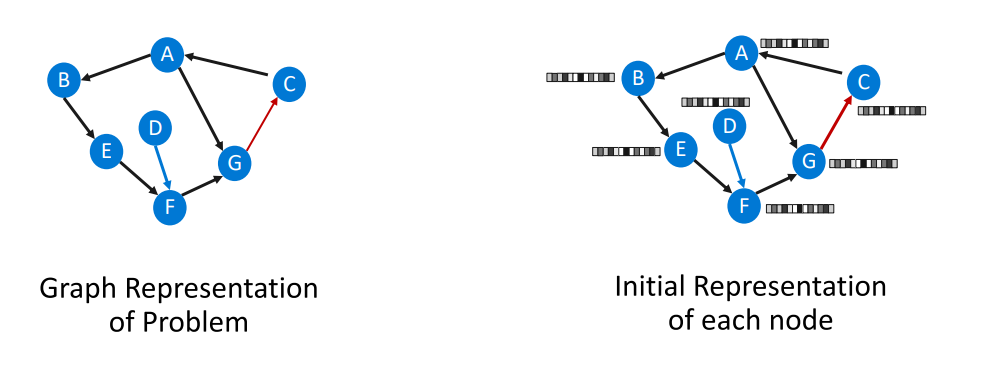

*Image Source: [An Introduction to Graph Neural Networks: Models and Application ](https://www.youtube.com/watch?v=zCEYiCxrL_0&t=824s)*

The GNN updates these node representations during training, outputting task-specific output representations. An overview of this process is illustrated below:

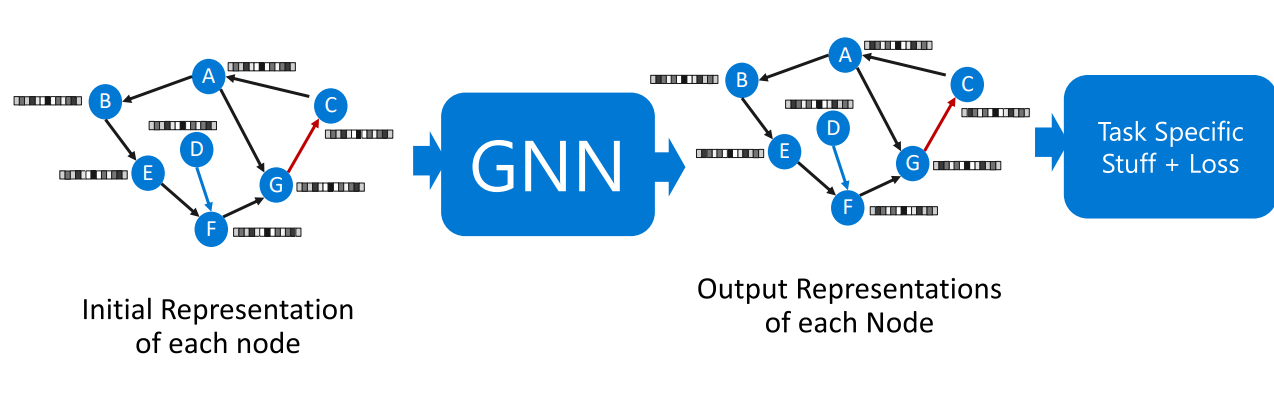


*Image Source: [An Introduction to Graph Neural Networks: Models and Application ](https://www.youtube.com/watch?v=zCEYiCxrL_0&t=824s)*

Neural Message Passing is a popular framework to perform this update. In a nutshell, each node representation is updated by exchanging information with the neighbouring nodes. To examine the node update in detail, let's consider a smaller neighbourhood of the graph such as nodes D, E and F pictured below.

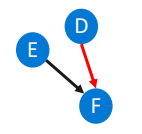

To update the vector representation of node F, we consider the following:

- Current vector representation of node F
- Vector representations of all nodes connected to F (e.g. E and D).
- Edge types of connected nodes.  

For each neighbour node (e.g. E and F) we compute a 'message' using some function $f$, which takes in the adjacent node representation and edge type as input. The output of function $f$ is the message vector. There are a vareity of different functions we could use to prepare this message and we'll go into some concrete examples later in the tutorial.

The messages from all the adjacent nodes are then summarized and used to update the current node state. The diagram below illustrates this process, whereby the vector representation of node F at time $t$ is labelled as $h^{n}_{t-1}$.

The notation is as follows:
- $t$ = timestep
- $h$ = node vector representation
- $k$ = edge type
- $f$ = function which prepares a message
- $⋃$ = function which summarised the messages
- $q$ = node update function

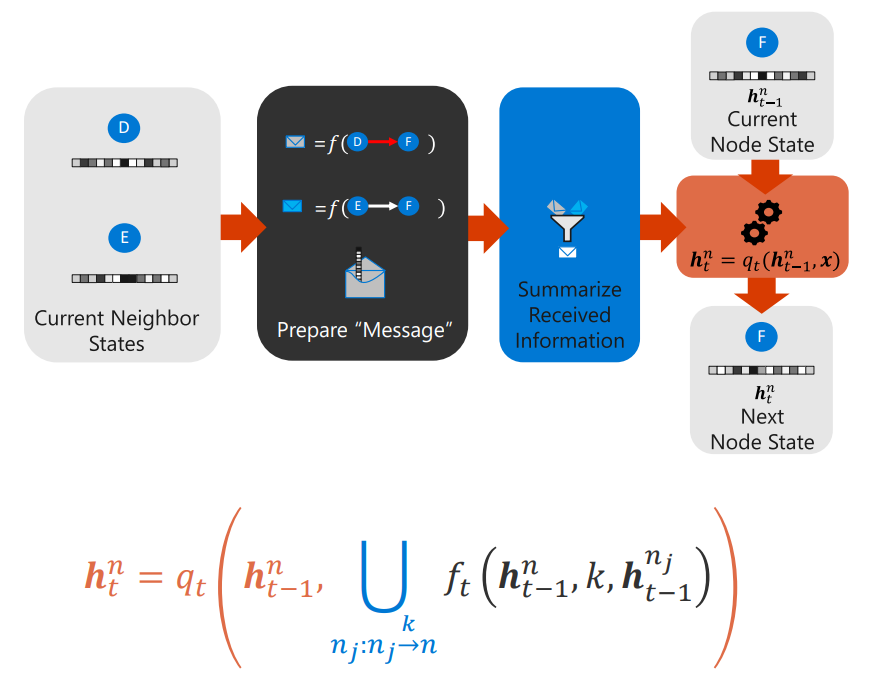

*Image Source: [An Introduction to Graph Neural Networks: Models and Application ](https://www.youtube.com/watch?v=zCEYiCxrL_0&t=824s)*

The equation at the bottom of the image is coloured coded to match the step in the diagram. For example, black represents the function to prepare the message, blue the function to summarise these messages and orange to update the node step.

Note that $⋃$ must be permutation invariant, as the messages are not ordered.

### **3.2. Graph Prediction Tasks**

What are the kinds of problems we want to solve on graphs?


The tasks fall into roughly three categories:

1. **Node Classification**: E.g. what is the topic of a paper given a citation network of papers?
2. **Link Prediction / Edge Classification**: E.g. are two people in a social network friends?
3. **Graph Classification**: E.g. is this protein molecule (represented as a graph) likely going to be effective?

<image src="https://storage.googleapis.com/dm-educational/assets/graph-nets/graph_tasks.png" width="700px">

*The three main graph learning tasks. Image source: Petar Veličković.*

Which examples of graph prediction tasks come to your mind? Which task types do they correspond to?


### **3.3. Formulating Recommender systems as a graph problem**

 A recommender system can be visualized as a graph, where entities (such as users and items) are nodes, and the interactions between them (such as ratings or purchase history) are edges. In the context of a movie recommendation system:

- Nodes represent:
    - Users: Individuals consuming the content.
    - Movies: Content items to be recommended.
- Edges represent:
    - Ratings: A directed edge from a user to a movie, annotated with a weight that indicates the rating (e.g., on a scale of 1 to 5).



#### **3.3.1. Link (or Edge) Prediction**

One of the foundational tasks in graph-based recommender systems is link prediction. In essence, link prediction tries to predict whether a link (or edge) should exist between two nodes, even if it's currently absent. For our movie recommendation system, this translates to predicting whether a user would like (or dislike) a movie they haven't yet rated.

The process works as follows:
1. Train on existing edges: Use known ratings (edges) from users to movies to train a model.
2. Predict missing edges: For a given user, predict ratings for movies they haven't seen or rated. This is akin to predicting missing or potential edges in our graph.
3. Recommend based on predictions: Movies with the highest predicted ratings are recommended to the user.

In this section of the tutorial, we will leverage graph neural networks (GNNs) for this link prediction task. The GNNs operate on the graph, aggregating information from neighboring nodes to produce accurate predictions for unseen edges. The below figure showcases a user-item sub-knowledge graph. Each icon denotes an entity or concept, and the connecting lines or edges symbolize the relationships between them.

![Description](https://drive.google.com/uc?export=view&id=1OeP-Ufd1zK27IS7cNXug2TZ56NcqTX-B)

*Image source: [HI2Rec: Exploring Knowledge in Heterogeneous Information for Movie Recommendation](https://www.semanticscholar.org/paper/HI2Rec%3A-Exploring-Knowledge-in-Heterogeneous-for-He-Wang/038eb4e6839352c8fa8f9c4f5ae5ff958e14c5a3)*

In [2]:
#@title Load movielens dataset function
def load_movielens_dataframes():
    """
    Load the movielens/100k-ratings and movielens/100k-movies datasets from TFDS.

    Returns:
        ratings_df (pd.DataFrame): DataFrame containing the user ratings data.
        movies_df (pd.DataFrame): DataFrame containing the movie details.

    Example:
        ratings_df, movies_df = load_movielens_dataframes()
    """

    # Load the data
    ratings = tfds.load('movielens/100k-ratings', split="train", download=True)
    movies = tfds.load('movielens/100k-movies', split="train", download=True)

    # Convert ratings data to DataFrame
    ratings_records = [{
        'user_id': example['user_id'].numpy().decode('utf-8'),
        'movie_id': example['movie_id'].numpy().decode('utf-8'),
        'user_rating': example['user_rating'].numpy()
    } for example in ratings]
    ratings_df = pd.DataFrame(ratings_records)

    # Convert movies data to DataFrame
    movies_records = [{
        'movie_title': example['movie_title'].numpy().decode('utf-8'),
        'movie_id': example['movie_id'].numpy().decode('utf-8'),
        'movie_genres': list(example['movie_genres'].numpy()) # already encoded (e.g., 1 might correspond to "Action", 2 to "Comedy", and so forth)
    } for example in movies]
    movies_df = pd.DataFrame(movies_records)

    return ratings_df, movies_df

In [3]:
# load movielens data as pandas dataframe
ratings_df, movies_df = load_movielens_dataframes()

In [4]:
movies_df.head()

,movie_title,movie_id,movie_genres
0,You So Crazy (1994),1681,[4]
1,Love Is All There Is (1996),1457,"[4, 7]"
2,Fly Away Home (1996),500,"[1, 3]"
3,In the Line of Duty 2 (1987),838,[0]
4,"Niagara, Niagara (1997)",1648,[7]


In [5]:
ratings_df.head()

,user_id,movie_id,user_rating
0,138,357,4.0
1,92,709,2.0
2,301,412,4.0
3,60,56,4.0
4,197,895,3.0


In [6]:
movies_df.shape, ratings_df.shape

((1682, 3), (100000, 3))

In [7]:
print('number of unique movies: ', len(ratings_df.movie_id.unique()))
print('number of unique users: ', len(ratings_df.user_id.unique()))

number of unique movies:  1682
number of unique users:  943


Since our data is not structured as graph, we will use the below helper class to transform our tabular data into graph.

In [8]:
#@title Transform data into graph
class GraphDataPreparation:
    def __init__(
        self, ratings_df: pd.DataFrame, movies_df: pd.DataFrame, split = 0.2
    ):
        """
        Initialize the class with ratings and movies dataframes.

        Args:
            ratings_df: DataFrame with ratings data.
            movies_df: DataFrame with movies data.
        """
        self.ratings_df = ratings_df
        self.movies_df = movies_df

        # Create mappings for userId and movieId to new continuous indexes
        self.user_mapping = {
            user_id: i for i, user_id in enumerate(self.ratings_df.user_id.unique())
        }
        self.movie_mapping = {
            movie_id: i for i, movie_id in enumerate(self.ratings_df.movie_id.unique())
        }
        # Apply the mappings to set new continuous userIds and movieIds
        self.ratings_df["user_id"] = self.ratings_df["user_id"].map(self.user_mapping)
        self.ratings_df["movie_id"] = self.ratings_df["movie_id"].map(
            self.movie_mapping
        )
        self.movies_df["movie_id"] = self.movies_df["movie_id"].map(self.movie_mapping)
        # Initialize edge splitting transformation
        self.transform = RandomLinkSplit(is_undirected=False, num_val=split)

    def create_edge_index(self):
        """
        Create an edge index for the graph. Edge direction is from user to movie.

        Returns:
            A tensor representing the edge index.
        """
        user_nodes = self.ratings_df["user_id"].to_numpy()
        movie_nodes = (
            self.ratings_df["movie_id"].to_numpy()
            + self.ratings_df["user_id"].nunique()
        )

        edge_index = torch.tensor(np.array([user_nodes, movie_nodes]), dtype=torch.long)

        return edge_index

    def create_edge_features(self):
        """
        Create edge features for the graph.

        Returns:
            A tensor representing the edge features.
        """
        ratings = self.ratings_df["user_rating"].to_numpy()
        edge_attr = torch.tensor(ratings, dtype=torch.float).view(-1, 1)

        return edge_attr

    def create_node_features(self):
        """
        Create node features for the graph.

        Returns:
            A tensor representing the node features.
        """

        # Prepare movie features
        movie_genres = self.movies_df["movie_genres"].apply(lambda x: pd.Series(x))
        movie_features = (
            pd.get_dummies(movie_genres.stack()).groupby(level=0).sum().values
        )

        # Prepare user features
        num_users = self.ratings_df["user_id"].nunique()
        user_embeddings = torch.nn.Embedding(num_users, movie_features.shape[1])
        user_features = user_embeddings.weight.detach().numpy()

        # Combine user and movie features
        node_features = np.vstack([user_features, movie_features])
        node_features = torch.tensor(node_features, dtype=torch.float)

        return node_features

    def create_edge_mask(self, original_edge_index, edge_label_index):
        # Convert the edges to a set of tuples for easy lookup
        label_edges_set = set([tuple(x) for x in edge_label_index.t().numpy()])

        # Generate the mask by checking each edge in original_edge_index
        mask = [tuple(x) for x in original_edge_index.t().numpy()]
        mask = [edge in label_edges_set for edge in mask]

        return np.array(mask)[:, None]

    def convert_to_jraph(self, data):
        """ Convert the Pytorch Data Object """
        graph = jraph.GraphsTuple(
            nodes=np.array(data.x),
            edges=np.array(data.edge_attr),
            n_node=np.array([data.num_nodes]),
            n_edge=np.array([data.num_edges]),
            senders=np.array(data.edge_index[0]),  # users are source
            receivers=np.array(data.edge_index[1]),  # movies are recievers
            globals=np.array([])
        )
        return graph

    def prepare_data(self):
        """
        Prepare the graph data.

        Returns:
            A train and test PyG Data object with the prepared graph data.
        """
        edge_index = self.create_edge_index()
        edge_attr = self.create_edge_features()
        node_features = self.create_node_features()
        graph = Data(x=node_features, edge_index=edge_index, edge_attr=edge_attr)
        train_graph, val_graph, test_graph = self.transform(graph)

        train_mask = self.create_edge_mask(graph.edge_index, train_graph.edge_label_index)
        val_mask = self.create_edge_mask(graph.edge_index, val_graph.edge_label_index)
        test_mask = self.create_edge_mask(graph.edge_index, test_graph.edge_label_index)
        graph = self.convert_to_jraph(graph)
        return graph, train_mask, val_mask, test_mask


In [9]:
# Convert data into graph
graph_prep = GraphDataPreparation(ratings_df = ratings_df.copy(), movies_df = movies_df.copy(), split=0.4)
graph, train_mask, val_mask, test_mask = graph_prep.prepare_data()
graph.edges.shape

(100000, 1)

We will use graph convolution neural network (GCN) as our model. For more in-depth understanding of GCN, please go throught the above provided resources in your free time.

In [10]:
#@title Model
class MLP(nn.Module):
  """A flax MLP."""
  features: Sequence[int]
  kernel_init: Callable = jax.nn.initializers.he_uniform()
  bias_init: Callable = jax.nn.initializers.zeros

  @nn.compact
  def __call__(self, inputs):
    x = inputs
    for i, feat in enumerate(self.features):
        lyr = nn.Dense(feat, kernel_init=self.kernel_init, bias_init=self.bias_init, name=f"mlp_dense_{i}")
        x = lyr(x)
        x = nn.relu(x)
        if i != len(self.features) - 1:
            x = nn.relu(x)
    return x

def make_embed_fn(latent_size):
    def embed(inputs):
        return nn.Dense(latent_size)(inputs)
    return embed

class GraphConvLayer(nn.Module):

  output_decoder_dim: int
  latent_size: int
  update_node_fn: Callable
  aggregate_nodes_fn: Callable = jax.ops.segment_sum
  add_self_edges: bool = False
  symmetric_normalization: bool = True
  layer_norm: bool = False

  @nn.compact
  def __call__(self, graph):
    gcn = GraphConvolution(
        update_node_fn=self.update_node_fn,
        aggregate_nodes_fn=self.aggregate_nodes_fn,
        add_self_edges=self.add_self_edges,
        symmetric_normalization=self.symmetric_normalization
    )
    graph = gcn(graph)
    if self.layer_norm:
      # Apply layer normalization to the node embeddings
      normalized_nodes = nn.LayerNorm()(graph.nodes)
      # Update the graph with the normalized node embeddings
      graph = graph._replace(nodes=normalized_nodes)

    edge_predictions = jnp.sum(graph.nodes[graph.senders] * graph.nodes[graph.receivers], axis=-1)
    edge_predictions = jnp.expand_dims(edge_predictions, axis=1)
    edge_predictions = nn.Dense(self.output_decoder_dim, name="mlp_dense_output")(edge_predictions)

    # Apply sigmoid activation and scale it 
    edge_predictions = 4 * jax.nn.sigmoid(edge_predictions) + 1
    return edge_predictions

In [11]:
# Define one layer gcn
gcn_layer = GraphConvLayer(
    output_decoder_dim = 1,
    latent_size = 64,
    update_node_fn=lambda n: MLP(features=[64, 64])(n),
    aggregate_nodes_fn=jax.ops.segment_sum,
    add_self_edges=False,
    symmetric_normalization=True
)

# Initialize to see the output shapes
params = gcn_layer.init(jax.random.PRNGKey(42), graph)
output = gcn_layer.apply(params, graph)
output.shape, graph.edges.shape

((100000, 1), (100000, 1))

In [12]:
# Define loss function
def l1_loss(logits: np.ndarray, y: np.ndarray, mask: np.array, reduction: str = "mean") -> np.ndarray:
    """Implementation of l1_loss.

    Args:
        logits: model output logits.
        y: class labels.
        reduction: if reduction is mean, the average is returned, else if it is sum, the sum is returned.

    Returns:
       l1 loss.
    """
    logits_masked = logits * mask.astype(int)
    preds_masked = y * mask.astype(int)
    if reduction == "mean":
        loss = jnp.mean(jnp.abs(logits_masked - preds_masked))
    if reduction == "sum":
        loss = jnp.sum(jnp.abs(logits_masked - preds_masked))

    return loss

# check random loss without training
l1_loss(output, graph.edges, mask=val_mask)

Array(0.40243, dtype=float32)

In [13]:
#@title Define flax train state
def create_train_state(
    model, graph, tx, rngs
):
    """Train state. This function initializes the model."""

    @jax.jit
    def initialize(params_rng):
        variables = model.init(
            params_rng,
            graph,
        )
        return variables

    variables = initialize(rngs)
    state = train_state.TrainState.create(apply_fn=model.apply, params=variables["params"], tx=tx)

    param_count = sum(x.size for x in jax.tree_util.tree_leaves(state.params))
    print("---> number of model parameters: ", param_count)
    return state

In [14]:
# Initialize model, train state, and other hparams
optimizer = optax.adam(learning_rate=0.001)
rng = jax.random.PRNGKey(0)
rng, init_rng = jax.random.split(rng)
rngs = {"params": rng, "dropout": init_rng}

model = GraphConvLayer(
    output_decoder_dim = 1,
    latent_size = 128,
    update_node_fn=lambda n: MLP(features=[128, 128, 64])(n),
    aggregate_nodes_fn=jax.ops.segment_sum,
    add_self_edges=True,
    layer_norm=True,
    symmetric_normalization=True
)
state = create_train_state(
    model=model,
    graph=graph,
    tx=optimizer,
    rngs=rngs,
)

---> number of model parameters:  27458


As you can see our model has 27458 parameters. You can play with this by changing hyper-parameters such as latent_size, MLP features, etc. Next, we will define train and evaluation steps and train the model.

In [15]:
# @title Train step
@jax.jit
def train_step(
    state: train_state.TrainState,
    graph: jnp.array,
    labels: jnp.ndarray,
    mask: jnp.ndarray,
    rngs: dict,
) -> Tuple[train_state.TrainState, tuple]:
    """Performs one update step over the graph.

    Args:
        state: training state.
        graph: graph node features.
        labels: graph edge labels.
        mask: mask for labels to consider for optimization
        rngs: rngs for droupout

    Returns:
        Current training state, the loss, and logits.
    """
    step = state.step
    rngs = {name: jax.random.fold_in(rng, step) for name, rng in rngs.items()}

    def loss_fn(params, graph, labels):
        # Compute logits and resulting loss.
        variables = {"params": params}
        logits = state.apply_fn(
            variables,
            graph=graph,
            rngs=rngs,
        )
        loss = l1_loss(logits=logits, y=labels, mask=mask)
        return loss, logits

    grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
    (loss, logits), grads = grad_fn(state.params, graph, labels)
    new_state = state.apply_gradients(grads=grads)
    return new_state, (loss, logits)


In [16]:
# @title Evaluation step
@jax.jit
def evaluate_step(
    state: train_state.TrainState,
    graph: jnp.array,
    labels: jnp.ndarray,
    mask: jnp.ndarray,
    dropout_rng: dict = None,
) -> tuple:
    """Performs evaluation step over a set of inputs."""
    variables = {"params": state.params}
    logits = state.apply_fn(
        variables,
        graph=graph,
        rngs=dropout_rng,
    )
    loss = l1_loss(logits=logits, y=labels, mask=mask)
    return (loss, logits)

In [17]:
# @title Train loop function
def train_eval(state, graph, train_mask, val_mask, rng, epochs = 10):
    final_train_loss = []
    final_val_loss = []
    for epoch in range(epochs):
        rng, epoch_rng = jax.random.split(rng)
        epoch_rng = {"dropout": epoch_rng}

        state, (train_loss, train_logits) = train_step(state=state, graph=graph, labels=graph.edges, mask=train_mask, rngs = epoch_rng)
        val_loss, val_logits = evaluate_step(state=state, graph=graph, mask=val_mask, labels=graph.edges)
        print(f"Epoch: {epoch}, train_loss: {train_loss}, val_loss: {val_loss}")
        final_train_loss.append(train_loss.item())
        final_val_loss.append(val_loss.item())

    return (state, final_train_loss, final_val_loss)

In [18]:
# train the model
epochs = 100
final_state, final_train_loss, final_val_loss = train_eval(state=state, graph=graph, train_mask=train_mask, val_mask=val_mask, rng=rng, epochs = epochs)

Epoch: 0, train_loss: 1.0100297927856445, val_loss: 1.0122629404067993
Epoch: 1, train_loss: 1.009941577911377, val_loss: 1.0101608037948608
Epoch: 2, train_loss: 1.0078167915344238, val_loss: 1.0110018253326416
Epoch: 3, train_loss: 1.0082863569259644, val_loss: 1.0111021995544434
Epoch: 4, train_loss: 1.0085268020629883, val_loss: 1.0110772848129272
Epoch: 5, train_loss: 1.0085755586624146, val_loss: 1.0108859539031982
Epoch: 6, train_loss: 1.0084689855575562, val_loss: 1.0103318691253662
Epoch: 7, train_loss: 1.0080524682998657, val_loss: 1.0089564323425293
Epoch: 8, train_loss: 1.0065855979919434, val_loss: 1.0087571144104004
Epoch: 9, train_loss: 1.0065542459487915, val_loss: 1.0083945989608765
Epoch: 10, train_loss: 1.0061006546020508, val_loss: 1.007629156112671
Epoch: 11, train_loss: 1.0049066543579102, val_loss: 1.0059946775436401
Epoch: 12, train_loss: 1.0033003091812134, val_loss: 1.0027445554733276
Epoch: 13, train_loss: 1.0001453161239624, val_loss: 0.9984414577484131
Epoc

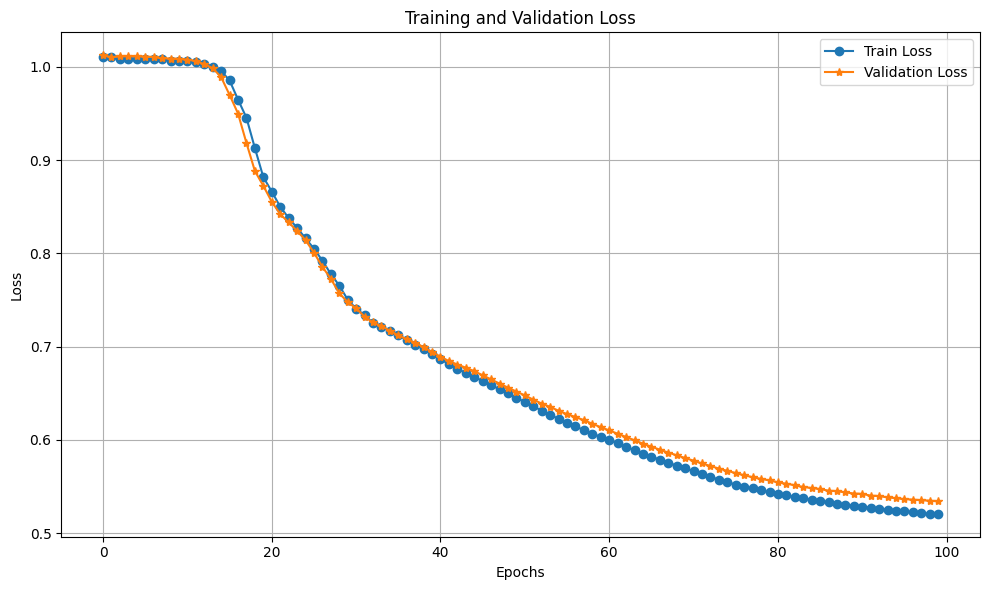

In [19]:
# Plotting losses
plt.figure(figsize=(10, 6))
plt.plot(range(epochs), final_train_loss, label="Train Loss", marker='o')
plt.plot(range(epochs), final_val_loss, label="Validation Loss", marker='*')
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#### **3.3.2. Inference**

In this section, we will show how we can recommend top N movies for a specific user based on the trained GNN. Since we already have a test set edges. We will use this to demonstrate the inference. We will do the following:

1. Extract test edges: With the test_mask, obtain the edges that belong to the test set.
2. Predict ratings: For each of these test edges, use the trained GNN to predict a rating.
3. Map to original data: Using the movie_mapping and user_mapping from the GraphDataPreparation class, convert the predicted edges back to the original movie and user IDs.
4. Get movie names: For the mapped movie IDs, fetch the actual movie names.
5. To get the top N recommended movies for a particular user, we will sort the movies based on the predicted ratings and then pick the top N movies for the user.


Below we will implement two functions to do the above steps for us.

In [20]:
def infer_movie_ratings(graph, state, test_mask, data_prep: GraphDataPreparation):
    """
    Infer movie ratings for the test set and map them to the original movies and users.

    Args:
        graph: The graph containing nodes and edges.
        state: The trained state of the model.
        test_mask: The mask indicating which edges belong to the test set.
        data_prep: The GraphDataPreparation instance used to process the data.

    Returns:
        A DataFrame containing user IDs, movie names, and predicted ratings.
    """

    # Using the test_mask, get the edges corresponding to the test set
    test_edge_senders = graph.senders[test_mask.squeeze()]
    test_edge_receivers = graph.receivers[test_mask.squeeze()] - len(data_prep.user_mapping)

    # Predict the ratings using the trained model
    _, logits = evaluate_step(state, graph, labels=graph.edges, mask=test_mask)
    predicted_ratings = logits[test_mask]

    # Map back to original user and movie IDs
    reverse_user_mapping = {v: k for k, v in data_prep.user_mapping.items()}
    reverse_movie_mapping = {v: k for k, v in data_prep.movie_mapping.items()}

    original_user_ids = np.array([reverse_user_mapping[v] for v in test_edge_senders]).astype(int)
    original_movie_ids = np.array([reverse_movie_mapping[v] for v in test_edge_receivers]).astype(int)

    # Revert the remapping on the movie_id column of the movies_df
    movies_df_original = data_prep.movies_df.copy()
    movies_df_original['movie_id'] = movies_df_original['movie_id'].map(reverse_movie_mapping).astype(int)

    # Get movie names using the original movie_ids
    movie_title = movies_df_original.set_index('movie_id').loc[original_movie_ids, 'movie_title'].values

    # Create a DataFrame with the results
    result_df = pd.DataFrame({
        'user_id': original_user_ids,
        'movie_name': movie_title,
        'predicted_rating': np.round(predicted_ratings, 3)
    })

    return result_df

predicted_ratings_df = infer_movie_ratings(graph, final_state, test_mask, graph_prep)
predicted_ratings_df.head()

,user_id,movie_name,predicted_rating
0,138,One Flew Over the Cuckoo's Nest (1975),4.277
1,92,Strictly Ballroom (1992),3.462
2,301,"Very Brady Sequel, A (1996)",1.000
3,881,"Jungle Book, The (1994)",3.740
4,372,Pulp Fiction (1994),1.000


In [23]:
def get_top_n_recommendations(df, user_id, N=10):
    """
    Get the top N recommended movies for a user.

    Args:
        df (pd.DataFrame): DataFrame containing user IDs, movie title, and predicted ratings.
        user_id (int): The user ID for whom the recommendations are to be fetched.
        N (int): The number of top movies to fetch.

    Returns:
        A list of top N movie title for the user.
    """

    # Filter out the movies for the given user and sort them based on predicted ratings in descending order
    top_movies = df[df['user_id'] == user_id].sort_values(by='predicted_rating', ascending=False).head(N)

    return top_movies['movie_name'].tolist()

# choose user ID to get it's N ratings
user_id = 600
N = 10
top_10_movies = get_top_n_recommendations(predicted_ratings_df, user_id, N)
print(f'Top {len(top_10_movies)} movies recommended for user ID: {user_id} are: ')

for number, movie_title in enumerate(top_10_movies):
    print(f'{number}: {movie_title}')

Top 10 movies recommended for user ID: 600 are: 
0: Lawrence of Arabia (1962)
1: Man Who Would Be King, The (1975)
2: Terminator 2: Judgment Day (1991)
3: Raiders of the Lost Ark (1981)
4: Army of Darkness (1993)
5: True Romance (1993)
6: Young Guns (1988)
7: Alien (1979)
8: Godfather: Part II, The (1974)
9: Indiana Jones and the Last Crusade (1989)


## Conclusion
**Summary:**

[Summary of the main points/takeaways from the prac.]

**Next Steps:**

[Next steps for people who have completed the prac, like optional reading (e.g. blogs, papers, courses, youtube videos). This could also link to other pracs.]

**Appendix:**

[Anything (probably math heavy stuff) we don't have space for in the main practical sections.]

**References:**

[References for any content used in the notebook.]

For other practicals from the Deep Learning Indaba, please visit [here](https://github.com/deep-learning-indaba/indaba-pracs-2023).

## Feedback

Please provide feedback that we can use to improve our practicals in the future.

In [ ]:
# @title Generate Feedback Form. (Run Cell)
from IPython.display import HTML

HTML(
    """
<iframe
	src="https://forms.gle/Cg9aoa7czoZCYqxF7",
  width="80%"
	height="1200px" >
	Loading...
</iframe>
"""
)

<img src="https://baobab.deeplearningindaba.com/static/media/indaba-logo-dark.d5a6196d.png" width="50%" />